# Predictive Modeling Challenge (Topic Model Features)

**Mark Wilber**

The challenge here is to build a classifier for 56 FDA food safety violation categories, which are very unbalanced (sizes spanning more than 3 orders of magnitude). There are two components/features:

* a boolean, `FDAISCRITICAL`, indicating whether the violation is 'critical' or not
* a description of the violation, `VIOCOMMENT`, which can range from 0 to 844 'words'

This notebook is an experimental variation on others, for which features for the logistic regression model are constructed from topic model weights, rather than directly from TF-IDF. A logistic regression is trained to obtain f1 scores and training times. (It does *not* work out well!)

<font color='darkgreen'>**As thise notebook is lengthy, readers will find it much easier to navigate with [Jupyter Nbextensions](https://github.com/ipython-contrib/jupyter_contrib_nbextensions) installed, and Table of Contents (2) selected:**</font>

## Preliminaries

**Next two lines are useful in the event of external code changes.**

In [1]:
%load_ext autoreload
%autoreload 2

### Python imports

**Next two lines are for pretty output for all prints in a Pandas cell, not just the last.**

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The `Mlib` modules loaded below can be obtained from [https://github.com/mw0/Mlib](https://github.com/mw0/Mlib).

<font color='darkred'>***Note: heatmap and other plotting routines are broken in matplotlib 3.1.1. Use an older or newer version!***</font>

**`utility` contains generally helpful data science stuff, while `plotHelpers` includes plot functions specifically.**

In [3]:
import sys
sys.path.append('/home/wilber/work/Mlib/utility')
sys.path.append('/home/wilber/work/Mlib/plotHelpers')
import utility as util
import plotHelpers as ph

In [4]:
from time import time, asctime, gmtime
t0 = time()

# from platform import node
import os
from os.path import exists
# import shutil
# from glob import glob
from random import random
from collections import Counter, OrderedDict
import gc		# garbage collection module
from pprint import pprint
import pickle
import timeit

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# import logging # This allows for seeing if the model converges. A log file is created.
# logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

print("Python version: ", sys.version_info[:])
print("Un-versioned imports:\n")
if 'sys' in sys.modules:
    print('sys', end="")
if 'utility' in sys.modules:
    print(', utility', end="")
if 'plotHelpers' in sys.modules:
    print(', plotHelpers', end="")
if 'platform' in sys.modules:
    print(', platform', end="")
if 'os' in sys.modules:
    print(', os', end="")
if 'os.path' in sys.modules:
    print(', os.path', end="")
if 'shutil' in sys.modules:
    print(', shutil', end="")
if 'glob' in sys.modules:
    print(', glob', end="")
if 'random' in sys.modules:
    print(', random', end="")
if 'collections' in sys.modules:
    print(', collections', end="")
if 'gc' in sys.modules:
    print(', gc', end="")
if 'pprint' in sys.modules:
    print(', pprint', end="")
if 'pickle' in sys.modules:
    print(', pickle', end="")
if 're' in sys.modules:
    print(', re', end="")
if 'timeit' in sys.modules:
    print(', timeit', end="")
if 'warnings' in sys.modules:
    print(', warnings', end="")

from dateutil import __version__ as duVersion
from dateutil.parser import parse
import re
import numpy as np
import pandas as pd
import pyreadr

from scipy import __version__ as scVersion
import scipy.sparse as sp

# spacy for lemmatization
# import spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

from sklearn import __version__ as skVersion
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB

from joblib import __version__ as jlVersion
from joblib import dump, load

import seaborn as sns
import colorcet as cc
from matplotlib import __version__ as mpVersion
import matplotlib.pyplot as plt

print("\n")
if 'dateutil' in sys.modules:
    print("dateutil: {0}".format(duVersion), end="\t")
if 're' in sys.modules:
    print("re: {0}".format(re.__version__), end="\t")
if 'numpy' in sys.modules:
    print("numpy: {0}".format(np.__version__), end="\t")
if 'pandas' in sys.modules:
    print("pandas: {0}".format(pd.__version__), end="\t")
if 'pyreader' in sys.modules:
    print("pyreader: {0}".format(pyreader.__version__), end="\t")
if 'scipy' in sys.modules:
    print("scipy: {0}".format(scVersion), end="\t")
if 'spacy' in sys.modules:
    print("spacy: {0}".format(spacy.__version__), end="\t")
if 'gensim' in sys.modules:
    print("gensim: {0}".format(gensim.__version__), end="\t")
if 'pyLDAvis' in sys.modules:
    print("pyLDAvis: {0}".format(pyLDAvis.__version__), end="\t")
# if 'tensorflow' in sys.modules:
#     print("tensorflow: {0}".format(tfVersion), end="\t")
# if 'keras' in sys.modules:
#     print("keras: {0}".format(kerVersion), end="\t")
if 'sklearn' in sys.modules:
    print("sklearn: {0}".format(skVersion), end="\t")
if 'joblib' in sys.modules:
    print("joblib: {0}".format(jlVersion), end="\t")
if 'seaborn' in sys.modules:
    print("seaborn: {0}".format(sns.__version__), end="\t")
if 'colorcet' in sys.modules:
    print("colorcet: {0}".format(cc.__version__), end="\t")
if 'matplotlib' in sys.modules:
    print("matplotlib: {0}".format(mpVersion), end="\t")

%matplotlib inline

Python version:  (3, 7, 4, 'final', 0)
Un-versioned imports:

sys, utility, plotHelpers, platform, os, os.path, shutil, glob, random, collections, gc, pprint, pickle, re, timeit, warnings

dateutil: 2.8.0	re: 2.2.1	numpy: 1.16.4	pandas: 0.24.2	scipy: 1.3.0	gensim: 3.7.3	pyLDAvis: 2.1.2	sklearn: 0.21.2	joblib: 0.11	seaborn: 0.9.0	colorcet: 1.0.0	matplotlib: 3.1.0	

### Helper functions

#### Gensim-based helper functions

##### `sentenceToWords()`

* is a generator
* [`gensim.utils.simple_preprocess()`](https://radimrehurek.com/gensim/utils.html#gensim.utils.simple_preprocess) converts a string into a list of lowercase tokens, ignoring tokens that are too short or too long

##### `removeStopWords()`

* in addition to removing stop words, removes "'"s and "*"s, which appear often in FDA example

##### `bigrams()`

* uses [`gensim.models.phrases.Phrases()`](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.Phrases) first to detect phrases using colocation counts, and then [gensim.models.phrases.Phraser()](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.Phraser) to extract a more-efficient phrases model object. The phrases object will take words in succession and decide which to return as joined words (e.g., "ice" followed by "cream" ⟶ "ice_cream"). There is much magic in this function ...

##### `getCorpus()`

* given `df` and name of column containing text, `textCol`, returns
  * `corpus`:	list of sparse arrays containing message word counts, in the form [(wordIds), (counts)] (as in [(0, 7133, 76, ...), (2, 3, 4, ...)])
  * `id2word`:	{dict of (int, str), gensim.corpora.dictionary.Dictionary}) – Mapping from word IDs to words.
  * `bigram`:	list of lists of tokens as unigrams or underscored_bigrams

##### `getBigram()`

* For the test data we only need the bigram data built from the test data, as we'll use the id2word mappings from the train set. This is a requirement due to the shapes Gensim functions expect in the test-vector transformation below. With both these in hand, we can make the test corpus.
* given `df` and name of column containing text, `textCol`, returns
  * `bigram`:	list of lists of tokens as unigrams or underscored_bigrams
  * This is the test version of `getCorpus()`, in that `id2word` has already been found.

In [5]:
def sentenceToWords(sentences, maxLen=15):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), max_len=maxLen, deacc=True))		# deacc=True removes punctuations

def removeStopwords(texts):		# Removes "*"s and "'"s too
    return [[re.sub(r"['*]", "", word) for word in gensim.utils.simple_preprocess(str(doc)) if word not in stopWords] for doc in texts]

def bigrams(words, biMin=15, triMin=10):
    bigram = gensim.models.Phrases(words, min_count = biMin)
    bigramModel = gensim.models.phrases.Phraser(bigram)
    return bigramModel

@ph.timeUsage
def getCorpus(df, textCol):
    words = list(sentenceToWords(df[textCol]))
    words = removeStopwords(words)
    bigramModel = bigrams(words)
    bigram = [bigramModel[word] for word in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

@ph.timeUsage
def getBigram(df, textCol):
    words = list(sentenceToWords(df[textCol]))
    words = removeStopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
    return bigram

#### `plotConfusionMatrix()`

In [6]:
import seaborn as sns
import colorcet as cc

@ph.timeUsage
def plotConfusionMatrix(confusionMat, xlabels=None, ylabels=None,
                        type='counts', titleText=None, ax=None,
                        saveAs=None, xyfontSize=None, titleFontSize=None):

    if xlabels is None:
        xlabels = list(range(len(confusionMat) + 1))
    if ylabels is None:
        ylabels = list(range(len(confusionMat) + 1))

    if xyfontSize is None:
        xyfontSize = 20
    if titleFontSize is None:
        titleFontSize = 24

    if type == 'counts':
        name = 'Counts'
        fmtType = 'd'
        confusionMatNorm = confusionMat.copy()
    elif type == 'recall':
        name = 'Recall'
        fmtType = '0.2f'
        confusionMatNorm = (confusionMat.astype('float')/
                            confusionMat.sum(axis=1)[:, np.newaxis])
    elif type == 'precision':
        name = 'Precision'
        fmtType = '0.2f'
        confusionMatNorm = (confusionMat.astype('float')/
                            confusionMat.sum(axis=0)[np.newaxis, :])

    if titleText is not None:
        fileNameAugmentString = "".join([w.lstrip('(').rstrip(')')
                                         .capitalize() for w in \
                                         titleText.split(" ")])
    else:
        fileNameAugmentString = ""

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(30,25))
    sns.heatmap(confusionMatNorm, annot=True, fmt=fmtType, cmap=cc.cm.rainbow,
                xticklabels=xlabels, yticklabels=ylabels, ax=ax)
    plt.ylabel('Actual', fontsize=xyfontSize)
    plt.xlabel('Predicted', fontsize=xyfontSize)
    plt.suptitle(", ".join(['Confusion matrix', name, titleText]), fontsize=titleFontSize)
    if saveAs == 'pdf':
        plt.savefig("".join(['ConfusionMatrix', name,
                             fileNameAugmentString, '.pdf']))
    elif saveAs == 'png':
        plt.savefig("".join(['ConfusionMatrix', name,
                             fileNameAugmentString, '.png']))
    elif saveAs == 'svg':
        plt.savefig("".join(['ConfusionMatrix', name,
                             fileNameAugmentString, '.svg']))
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])

    return

## Handle the data

### Read data into a DataFrame

* Have a very quick look at DataFrame characteristics

In [7]:
fname = "SelectedInspectionReportData.rds"

result = pyreadr.read_r(fname)
df = result[None]
df.fda_q_fixed = df.fda_q_fixed.astype('int')
df.FDAISCRITICAL = df.FDAISCRITICAL.astype('int')
df.shape

(1307986, 12)

In [8]:
df.head(6).T
df.tail(6).T

,0,1,2,3,4,5
HZLVIOLATIONID,,,,,,
VIOCORRECTBYDATE,,,,,,
PICKLIST,6-301.11,4-601.11(A),4-204.112,3-302.12,6-404.11,4-501.11
VIOCOMMENT,Soap and/or paper towels are not provided for ...,Food contact surfaces and utensils are not cle...,An accurate product temperature-measuring devi...,Bulk containers are not properly labeled. V/C,Food products that are held by the food establ...,Non-food contact equipment is not maintained i...
FDAQUESTION,8,14,34,35,37,45
VIOISCOS,1,1,1,1,1,1
VIOLATIONID,,,,,,
FDAISCRITICAL,0,0,1,1,1,1
VIOISRPT,,,,,,
VIOCODE,,,,,,


,1307980,1307981,1307982,1307983,1307984,1307985
HZLVIOLATIONID,,,,,,
VIOCORRECTBYDATE,"January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00"
PICKLIST,6-501.11,6-501.12(1),3-305.11,4-903.11 (42),4-903.11 (42),4-501.11
VIOCOMMENT,"Floors, walls, and ceilings not in good repair","Floors, walls, and ceilings not clean",Food was not separated and protected from cont...,Equipment and utensils not properly installed ...,Equipment and utensils not properly stored or ...,Utensils and equipment unapproved or not in go...
FDAQUESTION,53,53,37,42,42,45
VIOISCOS,0,0,0,0,0,0
VIOLATIONID,100960663,100960664,100960679,100960681,100960682,100960680
FDAISCRITICAL,0,0,0,0,0,0
VIOISRPT,0,0,0,0,0,0
VIOCODE,53,53,37,45,42,45


#### Basic summary

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307986 entries, 0 to 1307985
Data columns (total 12 columns):
HZLVIOLATIONID      1307986 non-null object
VIOCORRECTBYDATE    1307986 non-null object
PICKLIST            1307986 non-null object
VIOCOMMENT          1307986 non-null object
FDAQUESTION         1307986 non-null object
VIOISCOS            1307986 non-null object
VIOLATIONID         1307986 non-null object
FDAISCRITICAL       1307986 non-null int64
VIOISRPT            1307986 non-null object
VIOCODE             1307986 non-null object
JURISDICTIONID      1307986 non-null float64
fda_q_fixed         1307986 non-null int64
dtypes: float64(1), int64(2), object(9)
memory usage: 119.7+ MB


In [10]:
df.describe()

,FDAISCRITICAL,JURISDICTIONID,fda_q_fixed
count,1.307986e+06,1.307986e+06,1.307986e+06
mean,3.141234e-01,2.818328e+02,3.773050e+01
std,4.641660e-01,2.400974e+02,1.619210e+01
min,0.000000e+00,2.000000e+00,1.000000e+00
25%,0.000000e+00,1.360000e+02,2.200000e+01
50%,0.000000e+00,1.530000e+02,4.400000e+01
75%,1.000000e+00,3.880000e+02,5.000000e+01
max,1.000000e+00,9.730000e+02,5.600000e+01


#### Remove columns from DataFrame which we won't need

In [11]:
df = df[['fda_q_fixed', 'VIOCOMMENT', 'FDAISCRITICAL']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307986 entries, 0 to 1307985
Data columns (total 3 columns):
fda_q_fixed      1307986 non-null int64
VIOCOMMENT       1307986 non-null object
FDAISCRITICAL    1307986 non-null int64
dtypes: int64(2), object(1)
memory usage: 29.9+ MB


### Exploratory analysis

#### Classes and relative balance

* The stuff using patches is for placing counts above each rectangle in the bar plot

In [12]:
classCts = pd.DataFrame(df['fda_q_fixed'].value_counts())
with pd.option_context("display.max_columns", 60):
    display(classCts.T)

,55,49,47,16,10,22,51,56,39,44,41,38,54,48,43,28,40,45,36,8,21,15,6,24,53,37,23,2,33,1,50,20,13,9,52,35,3,29,18,25,5,11,19,14,4,42,31,46,17,12,32,7,26,30,27,34
fda_q_fixed,171202,122314,121997,103357,69288,57210,56230,51223,46145,45333,42241,37133,30016,27602,26638,24426,24016,22845,21351,20585,18874,18156,15947,15218,13428,13294,12675,12630,11494,7844,7019,5747,5495,4213,3738,3513,2774,1910,1859,1770,1602,1550,1351,933,883,849,492,464,348,225,216,166,63,34,33,27


Δt:  0.59s.


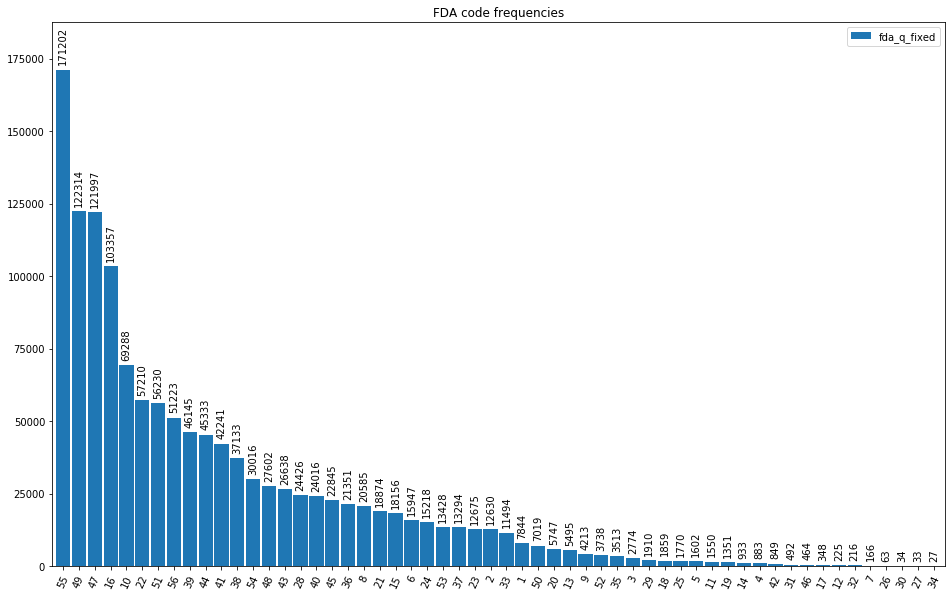

In [13]:
ph.plotValueCounts(df, 'fda_q_fixed', titleText='FDA code frequencies', saveAs='svg', ylim=[0.0, 187500.0])

***The class sizes span nearly 4 orders of magnitude!***

#### Word frequencies

In [14]:
t0 = time()
df['commentsWords'] = df['VIOCOMMENT'].apply(lambda s: s.split())
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

Δt:  6.7s.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
comments = list(df['commentsWords'])

##### Distribution of comment lengths

* Add length of each comment to DataFrame as `wordFreq` column

In [16]:
wordLens = [len(wordList) for wordList in comments]
df['wordFreq'] = wordLens
wordFreqMode = df['wordFreq'].mode().values[0]

wordCtSorted = sorted(wordLens)
print("smallest word counts:\n", wordCtSorted[:100])
print("largest word counts:\n", wordCtSorted[-101:-1])

smallest word counts:
 [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
largest word counts:
 [434, 434, 434, 440, 440, 440, 440, 440, 440, 441, 441, 442, 453, 454, 454, 458, 464, 464, 464, 464, 464, 464, 466, 466, 474, 474, 476, 476, 476, 480, 480, 481, 481, 481, 488, 498, 498, 498, 498, 503, 506, 506, 511, 511, 511, 533, 533, 534, 534, 535, 535, 536, 536, 536, 538, 538, 539, 542, 542, 542, 547, 552, 552, 553, 553, 564, 577, 577, 580, 580, 580, 580, 580, 580, 594, 594, 615, 615, 615, 619, 619, 619, 628, 628, 644, 644, 644, 649, 649, 670, 670, 670, 671, 671, 782, 782, 787, 787, 806, 806]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Detailed histogram**

Found  844 bins in data array.
Saving as  WordCountsHistWordCountsMax844Mode8.svg .
Δt:  3.17s.


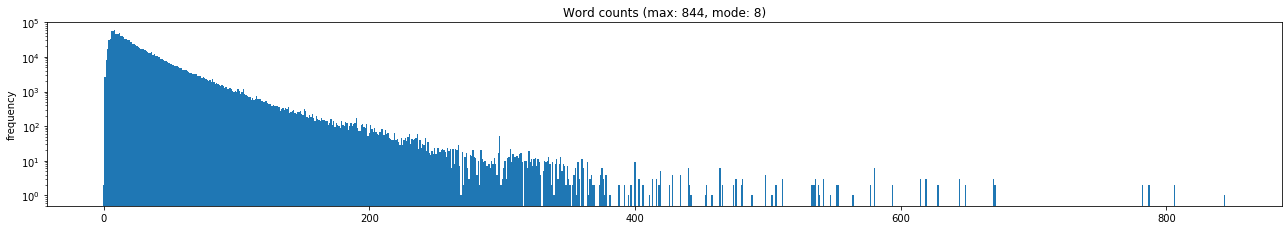

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(18, 3.5))

ph.detailedHistogram(wordLens, ylabel='frequency', volubility=2,
                     titleText=f"Word counts (max: {wordCtSorted[-1]}, mode: {wordFreqMode})",
                     figName="WordCountsHist", ax=ax, ylim = [0.5, 100000.0], ylog=True, saveAs='svg')

**Make space**

In [18]:
del wordLens
del wordCtSorted
del df['commentsWords']

##### What FDA codes correspond to those comments having `wordFreq== 0`?

In [19]:
df[df['wordFreq']==0]
print("\n", df.shape)

,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL,wordFreq
610833,49,,1,0
610835,49,,1,0



 (1307986, 4)


**Can safely remove a couple of records from the 2nd-most populated category**

* Originally there were 1307986 records in `df`, out of which 122314 were in Class 49

In [20]:
df = df[df['wordFreq']!=0]
df.shape

(1307984, 4)

##### `wordFreq` percentiles

* These show that would get 99% coverage of the comments without truncation if were to use, say, 140-element LSTMs

In [21]:
df.describe(percentiles=[0.01, 0.05, 0.15, 0.25, 0.5, 0.75, 0.85, 0.95, 0.99])

,fda_q_fixed,FDAISCRITICAL,wordFreq
count,1.307984e+06,1.307984e+06,1.307984e+06
mean,3.773048e+01,3.141223e-01,2.734516e+01
std,1.619211e+01,4.641656e-01,2.859241e+01
min,1.000000e+00,0.000000e+00,1.000000e+00
1%,2.000000e+00,0.000000e+00,3.000000e+00
5%,9.000000e+00,0.000000e+00,5.000000e+00
15%,1.600000e+01,0.000000e+00,7.000000e+00
25%,2.200000e+01,0.000000e+00,1.000000e+01
50%,4.400000e+01,0.000000e+00,1.800000e+01
75%,5.000000e+01,1.000000e+00,3.500000e+01


#### Most-common words

In [22]:
t0 = time()
allWords = [word.lower() for wordList in comments for word in wordList]		# Flatten list of lists of words
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")
print(len(comments), len(allWords))

print(comments[:5], "\n", allWords[:25])

Δt:  4.6s.
1307986 35767027
[['Soap', 'and/or', 'paper', 'towels', 'are', 'not', 'provided', 'for', 'use', 'at', 'the', 'hand', 'wash', 'lavatory.', 'V/C'], ['Food', 'contact', 'surfaces', 'and', 'utensils', 'are', 'not', 'clean', 'to', 'sight', 'and', 'touch.', 'V/C'], ['An', 'accurate', 'product', 'temperature-measuring', 'device', 'is', 'not', 'provided.', 'V/C'], ['Bulk', 'containers', 'are', 'not', 'properly', 'labeled.', 'V/C'], ['Food', 'products', 'that', 'are', 'held', 'by', 'the', 'food', 'establishment', 'for', 'credit,', 'redemption', 'or', 'return', 'to', 'the', 'distributor', 'are', 'not', 'segregated', 'and', 'held', 'in', 'designated', 'areas', 'that', 'are', 'separated', 'from', 'food,', 'equipment,', 'utensils,', 'linens,', 'and', 'single', 'use', 'utensils/articles.', 'V/C']] 
 ['soap', 'and/or', 'paper', 'towels', 'are', 'not', 'provided', 'for', 'use', 'at', 'the', 'hand', 'wash', 'lavatory.', 'v/c', 'food', 'contact', 'surfaces', 'and', 'utensils', 'are', 'not', '

In [23]:
wordCtr = Counter(allWords)

##### Most common words, after removing stop words

*Result looks very plausible*

In [24]:
stopWords = text.ENGLISH_STOP_WORDS.union(['-'])

wcStops = [k for k in wordCtr if k.lower() in stopWords]
for k in wcStops:
    del wordCtr[k]
wordCtr.most_common(40)

[('food', 545448),
 ('observed', 295868),
 ('clean', 217078),
 ('stored', 205514),
 ('basic', 173211),
 ('equipment', 172847),
 ('shall', 168244),
 ('sink', 150044),
 ('cooler', 140936),
 ('ice', 130090),
 ('floor', 125923),
 ('surfaces', 119426),
 ('employee', 116945),
 ('hand', 110896),
 ('water', 109192),
 ('contact', 99743),
 ('area', 99033),
 ('properly', 98154),
 ('prep', 96204),
 ('time', 93789),
 ('temperature', 93240),
 ('cold', 90528),
 ('used', 89561),
 ('utensils', 83494),
 ('**warning**', 83220),
 ('storage', 82360),
 ('use', 76025),
 ('holding', 74133),
 ('hot', 73366),
 ('inspection', 73333),
 ('control', 72827),
 ('machine', 72764),
 ('items', 70447),
 ('good', 68955),
 ('proper', 68500),
 ('area.', 68293),
 ('repair', 67501),
 ('soiled', 66672),
 ('corrected', 66656),
 ('sanitizer', 66362)]

#### Clean up

In [25]:
del allWords
del wordCtr

#### `fda_q_fixed` vs. `FDAISCRITICAL`

What is the relationship between the critical violation boolean and the FDA code?

In [26]:
dfCrit = df.groupby(['fda_q_fixed', 'FDAISCRITICAL']).count()
del dfCrit['VIOCOMMENT']
del dfCrit['wordFreq']
dfCrit.head(20)

dfCrit.reset_index(inplace=True)
dfCrit.head(20)

Empty DataFrame
Columns: []
Index: [(1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1), (5, 0), (5, 1), (6, 0), (6, 1), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0)]

,fda_q_fixed,FDAISCRITICAL
0,1,0
1,1,1
2,2,0
3,2,1
4,3,0
5,3,1
6,4,0
7,4,1
8,5,0
9,5,1


Text(0.5, 0.98, 'Critical violations vs FDA code')

(0.5, 56.5)

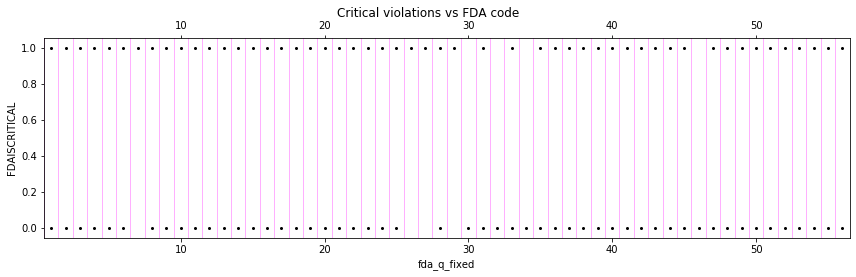

In [27]:
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.labeltop'] = True

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dfCrit.plot.scatter('fda_q_fixed', 'FDAISCRITICAL', s=4, c='black', ax=ax)
for xv in np.linspace(0.5, 56.5, 57):
    plt.axvline(x=xv, c="#FFB0FF", linewidth=1)
plt.suptitle('Critical violations vs FDA code')
ax.set_xlim([0.5, 56.5])
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('CriticalViolationVsFDAcode.pdf')

**The critical violations plot shows that FDAISCRITICAL should be predictive (and certainly should be included in the model):**

* classes 30, 32, 34 & 46 *never* have critical violations
* classes 7, 26, 27 & 29 *only* have critical violations

## Pre-process data

* Here we use TF-IDF features to represent the comment text.

### Split `df` by class into `dfTrain`, `dfTest`

`splitDataFrameByClasses()` will create two new DataFrames, dfTrain, dfTest, according to the desired splits.

In [28]:
classColumn = 'fda_q_fixed'
dfTrain, dfTest = util.splitDataFrameByClasses(df, classColumn,
                                               testFrac=0.50, myRandomState=28)
dfTrain.shape, dfTest.shape
dfTrain.head()
dfTest.head()

df.shape: (1307984, 4)
dfTrain.shape: (653979, 4)	dfTest.shape: (654005, 4)
Δt:  2.94s.


((653979, 4), (654005, 4))

,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL,wordFreq
0,22,High Priority - Potentially hazardous (time/te...,1,127
1,40,An employee at the egg station was observed wi...,0,14
2,56,An employee's personal drink was observed stor...,0,14
3,16,Knife on knife rack on cook line and cutting b...,1,30
4,55,Basic - Floors not constructed to be easily cl...,0,22


,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL,wordFreq
0,55,Floor drain under the pre-flush station is soi...,0,8
1,49,"Accumulation of dirt, food debris, and/or grea...",0,51
2,10,Employee hand wash sign not present in mens re...,1,10
3,49,Equipment is unclean and maintained in an unsa...,0,9
4,8,Employee observed not washing hands after touc...,1,33


**As intended, `splitDataFrameByClasses()` created a new test and train DataFrames with 653979 ~ 1307984/2 rows.**

*The test DataFrame is not exactly an even split of the original, since the splitting is done by class (which may have odd counts) and unioned.*

**The following is a medley of code and ideas from Machine Learning Plus's [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/) and Marc Kelechava's [Using LDA Topic Models as a Classification Model Input](https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28)**

### Extract comments, clean up and extract n-grams

##### stop words

In [29]:
from nltk.corpus import stopwords
stopWords = stopwords.words('english')
# stopWords.extend(['word0', 'word1', 'word2'])

/usr/local/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


#### Run `getCorpus()` to get LDA features, dicts

* given `df` and name of column containing text, `textCol`, returns
  * `corpus`:	list of sparse arrays containing message word counts, in the form [(wordIds), (counts)] (as in [(0, 7133, 76, ...), (2, 3, 4, ...)])
  * `id2word`:	{dict of (int, str), gensim.corpora.dictionary.Dictionary}) – Mapping from word IDs to words.
  * `bigram`:	list of lists of tokens as unigrams or underscored_bigrams

`getCorpus()` takes ~ 4m 30s.

In [30]:
trainCorpus, ID2word, bigramTrain = getCorpus(dfTrain, 'VIOCOMMENT')

Δt: 4m, 29.6s.


##### Introspection &mdash; What have we wrought?

In [31]:
type(trainCorpus), type(ID2word), type(bigramTrain)

(list, gensim.corpora.dictionary.Dictionary, list)

In [32]:
for l in trainCorpus[:5]:
    print(l)

[(0, 2), (1, 1), (2, 2), (3, 1), (4, 2), (5, 4), (6, 1), (7, 2), (8, 3), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 2), (29, 1), (30, 2), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 3), (38, 3), (39, 1), (40, 1), (41, 1), (42, 3), (43, 1), (44, 1), (45, 1), (46, 3)]
[(47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1)]
[(8, 1), (13, 1), (28, 1), (49, 1), (51, 1), (54, 1), (55, 1), (56, 1)]
[(57, 2), (58, 2), (59, 1), (60, 2), (61, 1), (62, 1), (63, 2)]
[(1, 1), (13, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1)]


In [33]:
for l in bigramTrain[:5]:
    print(l)

['high_priority', 'potentially_hazardous', 'time', 'temperature', 'control_safety', 'food', 'cold', 'held_greater', 'degrees_fahrenheit', 'diced_tomato', 'shredded', 'provolone_cheese', 'shredded_cheddar', 'cheese', 'blue_cheese', 'temped', 'top', 'bin', 'cookline', 'reach', 'cooler', 'refrigerator', 'diced_tomato', 'temped', 'inside', 'cookline', 'reach', 'cooler', 'refrigerator', 'shredded_cheddar', 'cheese', 'temped', 'cold', 'holding', 'refrigerated', 'bin', 'wait_station', 'according', 'manager', 'whitcomb', 'technician', 'serviced', 'cold', 'holding', 'units', 'morning', 'forgot_turn', 'back', 'units', 'manager', 'whitcomb', 'turned', 'cold', 'holding', 'units', 'putted', 'temperature', 'products', 'walk', 'cooler', 'cooling', 'according', 'mgr', 'whitcomb', 'products', 'temperature', 'since', 'less', 'hours', 'corrective_action', 'taken', 'warning']
['employee', 'egg', 'station', 'observed', 'wiping', 'hands', 'apron']
['employee', 'personal', 'drink', 'observed', 'stored', 'foo

In [34]:
i = 0
print(len(ID2word))
for thing in ID2word.items():
    if i > 15:
        break
    print(thing)
    i += 1

32989
(0, 'according')
(1, 'back')
(2, 'bin')
(3, 'blue_cheese')
(4, 'cheese')
(5, 'cold')
(6, 'control_safety')
(7, 'cookline')
(8, 'cooler')
(9, 'cooling')
(10, 'corrective_action')
(11, 'degrees_fahrenheit')
(12, 'diced_tomato')
(13, 'food')
(14, 'forgot_turn')
(15, 'held_greater')


### Train LDA model

* A key decision is to what the optimal number of topics should be set.
* An initial run to train the LDA model with 10 topics provided a pretty good distribution of topics, as visualized by `pyLDAvis`, but there was significant overlap in a few cases.
* Dropping down to 8 topics, in hopes that the topics remain well-distributed, but with less overlap.

*Takes 2+ hours to train*

In [35]:
import logging # This allows for seeing if the model converges. A log file is created.
logging.basicConfig(filename='ldaModel.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

LDAtrainName = 'ldaTrain.model'

if os.path.isfile(LDAtrainName):
    print(f"Loading previously-trained model {LDAtrainName}.")
    ldaTrain = gensim.models.ldamulticore.LdaMulticore.load(LDAtrainName)
else:
    print(f"No previously-trained model {LDAtrainName}. Training from scratch.")
    print(asctime(gmtime()))
    with warnings.catch_warnings():
        t0 = timeit.default_timer()

        warnings.simplefilter('ignore')
        ldaTrain = gensim.models.ldamulticore.LdaMulticore(
                        corpus=trainCorpus,
                        num_topics=8,
                        id2word=ID2word,
                        chunksize=100,
                        workers=7, # Num. Processing Cores - 1
                        passes=50,
                        eval_every = 1,
                        per_word_topics=True)
        t1 = timeit.default_timer()
        Δt = t1 - t0
        print(f"Δt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.")
        ldaTrain.save(LDAtrainName)
        t2 = timeit.default_timer()
        print(f"Δt: {Δt % 60.0:4.1f}s.")
    Δt = t2 - t0
    print(f"total Δt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.")

Loading previously-trained model ldaTrain.model.


/usr/local/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#### Examine the topics found



In [36]:
t0 = time()
pprint(ldaTrain.print_topics())
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

[(0,
  '0.061*"food" + 0.039*"employee" + 0.025*"employees" + 0.025*"hands" + '
  '0.023*"observed" + 0.023*"washing" + 0.021*"handwashing" + 0.013*"wash" + '
  '0.013*"shall" + 0.013*"area"'),
 (1,
  '0.066*"food" + 0.052*"contact" + 0.048*"clean" + 0.045*"surfaces" + '
  '0.036*"debris" + 0.033*"equipment" + 0.022*"ice" + 0.020*"observed" + '
  '0.020*"machine" + 0.018*"accumulation"'),
 (2,
  '0.064*"stored" + 0.058*"food" + 0.034*"utensils" + 0.028*"use" + '
  '0.025*"equipment" + 0.024*"storage" + 0.021*"containers" + 0.018*"items" + '
  '0.017*"clean" + 0.016*"contamination"'),
 (3,
  '0.106*"sink" + 0.050*"water" + 0.047*"hand" + 0.022*"area" + 0.019*"floor" '
  '+ 0.018*"mop" + 0.017*"drain" + 0.015*"intermediate" + 0.013*"machine" + '
  '0.013*"handwash"'),
 (4,
  '0.040*"food" + 0.038*"temperature" + 0.035*"time" + 0.025*"cold" + '
  '0.023*"holding" + 0.019*"foods" + 0.013*"hot" + '
  '0.013*"potentially_hazardous" + 0.012*"cooler" + 0.011*"unit"'),
 (5,
  '0.067*"cooler" + 

#### Extract test message vectors

##### Extract unigram/bigram tokens from dfTest (~4 minutes)

In [37]:
bigramTest = getBigram(dfTest, 'VIOCOMMENT')

Δt: 4m,  0.9s.


##### Extract `testCorpus` as sparse matrix (tokenIDs and counts) from `bigramTest`

In [38]:
t0 = time()
testCorpus = [ID2word.doc2bow(text) for text in bigramTest]
t1 = time()
Δt = t1 - t0
print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.\n")



Δt: 0m, 10.8s.



#### Get test message vectors (topic weights) (~7 minutes)

In [39]:
t0 = time()
Xtest = []
for i in range(len(dfTest)):
    topTopics = ldaTrain.get_document_topics(testCorpus[i], minimum_probability=0.0)
    topicVec = [topTopics[i][1] for i in range(8)]
    topicVec.extend([dfTest.iloc[i].FDAISCRITICAL]) # counts of messages
    Xtest.append(topicVec)
Xtest = np.array(Xtest)
t1 = time()
Δt = t1 - t0
print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.\n")
print(Xtest[:10])
print("\n", type(Xtest))



Δt: 6m, 32.8s.

[[0.01786887 0.01789811 0.01789785 0.26811218 0.01786955 0.28903273
  0.21015954 0.16116118 0.        ]
 [0.00543733 0.63679916 0.00544354 0.00544273 0.00543691 0.00544582
  0.33055878 0.00543571 0.        ]
 [0.37887985 0.0156738  0.0156783  0.21520543 0.14981754 0.01567298
  0.19340022 0.0156719  1.        ]
 [0.02500652 0.28620145 0.02501747 0.02501416 0.02500761 0.02500652
  0.56373733 0.02500898 0.        ]
 [0.49949723 0.00501385 0.37444028 0.00500366 0.10102849 0.0050025
  0.00500879 0.00500515 1.        ]
 [0.00500355 0.00501151 0.77005577 0.0050194  0.0050071  0.00500844
  0.00500538 0.19988883 0.        ]
 [0.00215995 0.00215909 0.07593245 0.00215825 0.82024688 0.07281767
  0.02236372 0.00216196 1.        ]
 [0.01565836 0.0156859  0.01562991 0.01563742 0.01563794 0.14284243
  0.01572146 0.76318663 0.        ]
 [0.00463208 0.09165717 0.00463191 0.00463818 0.88054079 0.00463551
  0.00463125 0.0046331  1.        ]
 [0.01792331 0.01788021 0.01792973 0.01787288 0

#### Target variable

In [40]:
yTrain = dfTrain['fda_q_fixed'].values
yTest = dfTest['fda_q_fixed'].values

##### Compute perplexity and coherence scores (~5 minutes)

In [41]:
t0 = time()
print('\nPerplexity: ', ldaTrain.log_perplexity(trainCorpus))
t1 = time()
Δt = t1 - t0
print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.")


Perplexity:  -6.656142059972426


Δt: 4m, 51.9s.


In [42]:
t0 = time()
coherenceModelLDA = CoherenceModel(model=ldaTrain, texts=bigramTrain, dictionary=ID2word, coherence='c_v')
t1 = time()
Δt = t1 - t0
print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.")
coherenceLDA = coherenceModelLDA.get_coherence()
print('\nCoherence Score: ', coherenceLDA)
t2 = time()
Δt = t2 - t1
print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.")



Δt: 0m,  0.0s.

Coherence Score:  0.643816463975474


Δt: 1m, 37.1s.


#### Visualize the topics/keywords (~27 minutes)

<font color='darkred'>***Note: for the example below, too much memory was filled with unrelated content, and this took 3 1/2 hours, due to significant swapping. Were swap to a hard disk, rather than a flash drive, it would have been much worse!***</font>

In [43]:
print(asctime(gmtime()))
t0 = time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldaTrain, trainCorpus, ID2word)
t1 = time()
Δt = t1 - t0
Δth = int(Δt//3600)
Δtm = int((Δt - 3600.0*Δth)//60)
print(f"\n\nΔt: {Δth}h, {Δtm}m, {Δt % 60.0:4.1f}s.")
vis

Sun Aug 18 04:02:22 2019


/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))




Δt: 213m, 16.0s.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.003841 -0.226804       1        1  19.188108
1     -0.024721  0.202632       2        1  16.327507
2     -0.128878  0.035027       3        1  15.031220
5      0.310959 -0.042959       4        1  11.563496
0     -0.164658 -0.115635       5        1  10.455743
3      0.228449  0.013846       6        1  10.147240
6     -0.075158  0.281230       7        1   9.051417
7     -0.142150 -0.147339       8        1   8.235265, topic_info=     Category           Freq                  Term          Total  loglift  \
123   Default  111824.000000                  sink  111824.000000  30.0000   
13    Default  348047.000000                  food  348047.000000  29.0000   
8     Default  104131.000000                cooler  104131.000000  28.0000   
56    Default  113934.000000                stored  113934.000000  27.0000   
92    Default   88157.000000               contact   88157.000000  26.0000   
66    Default   86569.000000                 basic   86569.000000  25.0000   
57    Default  144595.000000                 clean  144595.000000  24.0000   
94    Default   76415.000000              surfaces   76415.000000  23.0000   
38    Default   75094.000000           temperature   75094.000000  22.0000   
44    Default   65013.000000                  walk   65013.000000  21.0000   
74    Default   59014.000000                 water   59014.000000  20.0000   
114   Default   60850.000000                debris   60850.000000  19.0000   
85    Default   59803.000000                  hand   59803.000000  18.0000   
248   Default  127391.000000             equipment  127391.000000  17.0000   
39    Default   83755.000000                  time   83755.000000  16.0000   
90    Default   74748.000000             violation   74748.000000  15.0000   
161   Default   37725.000000             sanitizer   37725.000000  14.0000   
205   Default   42121.000000            maintained   42121.000000  13.0000   
49    Default   61842.000000              employee   61842.000000  12.0000   
28    Default   43789.000000                 reach   43789.000000  11.0000   
126   Default   72136.000000              utensils   72136.000000  10.0000   
407   Default   37729.000000               freezer   37729.000000   9.0000   
5     Default   49249.000000                  cold   49249.000000   8.0000   
552   Default   32552.000000           good_repair   32552.000000   7.0000   
17    Default   46097.000000               holding   46097.000000   6.0000   
271   Default   80212.000000                 floor   80212.000000   5.0000   
850   Default   33675.000000                  door   33675.000000   4.0000   
179   Default   75017.000000                   use   75017.000000   3.0000   
45    Default   42320.000000               warning   42320.000000   2.0000   
757   Default   27348.000000             employees   27348.000000   1.0000   
...       ...            ...                   ...            ...      ...   
1853   Topic8    2585.241699   quaternary_ammonium    2586.126953   2.4964   
602    Topic8    2552.846191      backflow_devices    2553.731445   2.4964   
863    Topic8    2527.630859         tight_fitting    2528.516602   2.4964   
3181   Topic8    2486.856445                knives    2487.743164   2.4964   
425    Topic8    2416.501465                 cloth    2417.387207   2.4964   
1569   Topic8    2364.993164              test_kit    2365.878418   2.4964   
2523   Topic8    2356.961426              pressure    2357.847412   2.4964   
1568   Topic8    2328.273682  sanitizing_solutions    2329.158936   2.4964   
454    Topic8    2005.596924          ceiling_tile    2006.483521   2.4963   
875    Topic8    1936.478516      minimum_strength    1937.363647   2.4963   
171    Topic8    4775.702148           dishmachine    5593.719727   2.3386   
525    Topic8    5891.663086                  uses    7277.6025

### Obtain classifier features from LDA model

#### Get train message vectors (topic weights) (~7 minutes)

In [44]:
t0 = time()
print(dfTrain.shape)
Xtrain = []
for i in range(len(dfTrain)):
    topTopics = ldaTrain.get_document_topics(trainCorpus[i], minimum_probability=0.0)
    if i < 5:
        print(i, "\n", topTopics)
    topicVec = [topTopics[i][1] for i in range(8)]
    topicVec.extend([dfTrain.iloc[i].FDAISCRITICAL]) # counts of messages
    Xtrain.append(topicVec)
Xtrain = np.array(Xtrain)
t1 = time()
Δt = t1 - t0
print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.\n")
print(Xtrain[:10])
print("\n", type(Xtrain))

(653979, 4)
0 
 [(0, 0.0017878319), (1, 0.0017911665), (2, 0.0017903103), (3, 0.039956428), (4, 0.8524517), (5, 0.09864737), (6, 0.0017875229), (7, 0.0017877583)]
1 
 [(0, 0.3453051), (1, 0.45855758), (2, 0.015637832), (3, 0.01564691), (4, 0.11792918), (5, 0.015657332), (6, 0.015632628), (7, 0.015633453)]
2 
 [(0, 0.013921012), (1, 0.013901049), (2, 0.6497879), (3, 0.013895297), (4, 0.013898387), (5, 0.2668108), (6, 0.013891951), (7, 0.013893605)]
3 
 [(0, 0.010418145), (1, 0.73765254), (2, 0.010442112), (3, 0.010429983), (4, 0.010420225), (5, 0.19979243), (6, 0.010426375), (7, 0.010418183)]
4 
 [(0, 0.008938171), (1, 0.25159532), (2, 0.008939896), (3, 0.30876848), (4, 0.008934494), (5, 0.117165744), (6, 0.28672412), (7, 0.008933763)]


Δt: 6m, 53.2s.

[[0.00178783 0.00179117 0.00179031 0.03995643 0.85245168 0.09864737
  0.00178752 0.00178776 1.        ]
 [0.34530509 0.45855758 0.01563783 0.01564691 0.11792918 0.01565733
  0.01563263 0.01563345 0.        ]
 [0.01392101 0.01390105 0.649

### Do some garbage collection before building models

In [45]:
del topTopics
del topicVec

In [46]:
for i in range(2):
    print('\nCollecting {} ...'.format(i))
    n = gc.collect()
    print('Unreachable objects:', n)
    print('Remaining Garbage:', end=' ')
    pprint(gc.garbage)


Unreachable objects: 83
Remaining Garbage: []

Unreachable objects: 0
Remaining Garbage: []


## Classifier

### Logistic Regression

#### LDA topics with `FDAISCRITICAL`

* Run defaults for now
* For np.shape(Xtr) = (560000, 180562), fit takes ~30 min.

In [47]:
np.shape(Xtrain), np.shape(yTrain), np.shape(Xtest), np.shape(yTest)

((653979, 9), (653979,), (654005, 9), (654005,))

In [48]:
print(asctime(gmtime()))
LR1name = 'LogisticRegressor2.joblib'

if os.path.isfile(LR1name):
    LR = load(LR1name)
    t1 = time()
else:
    CV = 5
    LR = LogisticRegression(random_state=0, n_jobs=7,
                            solver='newton-cg', class_weight='balanced')
    t0 = time()
    LR.fit(Xtrain, yTrain)
    t1 = time()
    Δt01 = t1 - t0
    print("Δt01: {0} m, {1:4.1f} s.".format(int(Δt01//60), Δt01 % 60.0))

yPred = LR.predict(Xtest)
t2 = time()
Δt12 = t2 - t1
print("Δt12: {0} m, {1:4.1f} s.".format(int(Δt12//60), Δt12 % 60.0))

Sun Aug 18 07:42:37 2019
Δt12: 0 m,  0.8 s.


In [49]:
print(yTest[:20])
print(yPred[:20])

[55 49 10 49  8 44 22 54 21 55 39 39 56 16 42 49 44 53 48 55]
[55 49 10 55  9 44 22 41 22 34 45 45 39 16 38 49 39 49 52 55]


**Save model to disk**

In [50]:
if not os.path.isfile(LR1name):
    dump(LR, LR1name)

#### Overall accuracy, precision, recall

In [51]:
confusionMat = confusion_matrix(yTest, yPred)
print(confusionMat)

[[   37    15     3 ...     0     0     0]
 [   67   104    23 ...     0     0     0]
 [   10    10     5 ...     0     0     0]
 ...
 [    0     0     0 ...  2948  1334   163]
 [    0     0     0 ...  2214 35444  1097]
 [    0     0     0 ...  1059  4608   461]]


In [52]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.422, <precision>: nan, <recall>: 0.225


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


##### Recall, precision by class

In [53]:
FDAcodes = list(set(dfTrain.fda_q_fixed))

print(metrics.classification_report(yTest, yPred, target_names=[str(c)for c in FDAcodes]))

/home/wilber/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           1       0.18      0.01      0.02      3922
           2       0.29      0.02      0.03      6315
           3       0.06      0.00      0.01      1387
           4       0.05      0.05      0.05       442
           5       0.12      0.43      0.18       801
           6       0.44      0.28      0.34      7974
           7       0.00      0.04      0.00        83
           8       0.24      0.33      0.28     10293
           9       0.14      0.19      0.16      2107
          10       0.81      0.76      0.78     34644
          11       0.01      0.02      0.02       775
          12       0.00      0.00      0.00       113
          13       0.07      0.00      0.01      2748
          14       0.05      0.08      0.06       467
          15       0.42      0.19      0.26      9078
          16       0.88      0.79      0.83     51679
          17       0.00      0.02      0.01       174
          18       0.06    

In [54]:
classCts = dfTest['fda_q_fixed'].value_counts()

recall = np.diag(confusionMat)/np.sum(confusionMat, axis = 1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis = 0)
f1 = 2.0*precision*recall/(precision + recall)
print("class\tprecision\trecall\tf1\tsize")

for FDAcode, classCt in classCts.iteritems():
    print(f"{FDAcode}\t{precision[FDAcode - 1]:0.3f}\t\t{recall[FDAcode - 1]:0.3f}\t{f1[FDAcode - 1]:0.3f}\t\t{classCt:d}")

class	precision	recall	f1	size
55	0.536		0.414	0.467		85601
49	0.531		0.736	0.617		61156
47	0.452		0.223	0.299		60999
16	0.875		0.790	0.830		51679
10	0.806		0.763	0.784		34644
22	0.474		0.785	0.591		28605
51	0.417		0.472	0.443		28115
56	0.111		0.018	0.031		25612
39	0.362		0.243	0.291		23073
44	0.322		0.541	0.404		22667
41	0.533		0.743	0.621		21121
38	0.288		0.249	0.267		18567
54	0.180		0.196	0.188		15008
48	0.141		0.050	0.074		13801
43	0.287		0.115	0.165		13319
28	0.515		0.647	0.573		12213
40	0.478		0.637	0.546		12008
45	0.196		0.281	0.231		11423
36	0.186		0.234	0.207		10676
8	0.244		0.331	0.281		10293
21	0.229		0.001	0.002		9437
15	0.417		0.191	0.262		9078
6	0.439		0.276	0.339		7974
24	0.356		0.032	0.059		7609
53	0.059		0.088	0.071		6714
37	0.234		0.097	0.138		6647
23	0.062		0.000	0.001		6338
2	0.291		0.016	0.031		6315
33	0.264		0.360	0.305		5747
1	0.185		0.009	0.018		3922
50	0.248		0.364	0.295		3510
20	nan		0.000	nan		2874
13	0.071		0.005	0.009		2748
9	0.144		0.191	0.164		2107
52	0.0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

The default font sizes and image size in `plotConfusionMatrix()` are not suitable for a 56 &times; 56 matrix.

In [57]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

Δt: 11.48s.


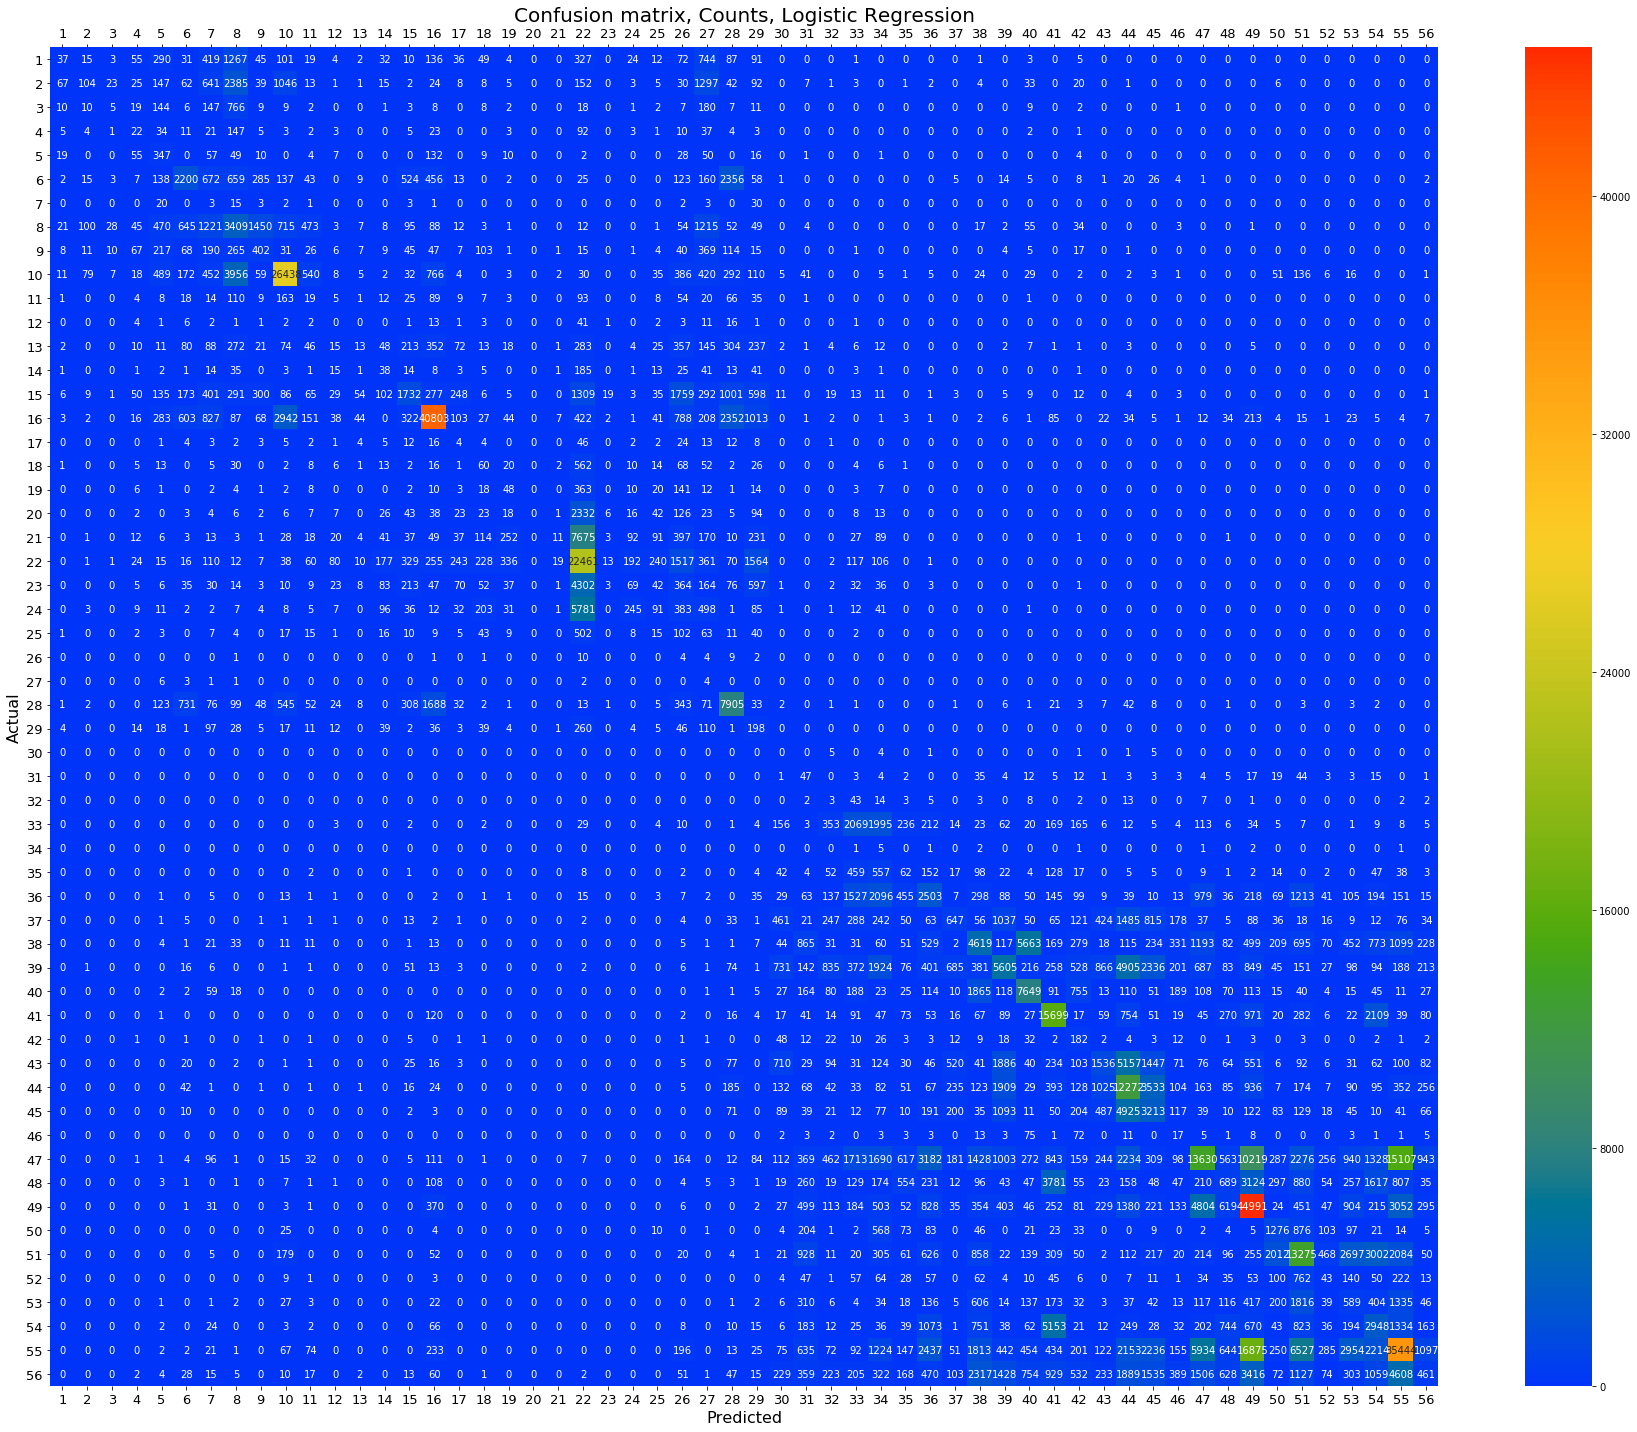

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='svg', xlabels=FDAcodes,
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix (normalized by row)

* diagonal elements now represent the *recall* for each class

Δt: 12.19s.


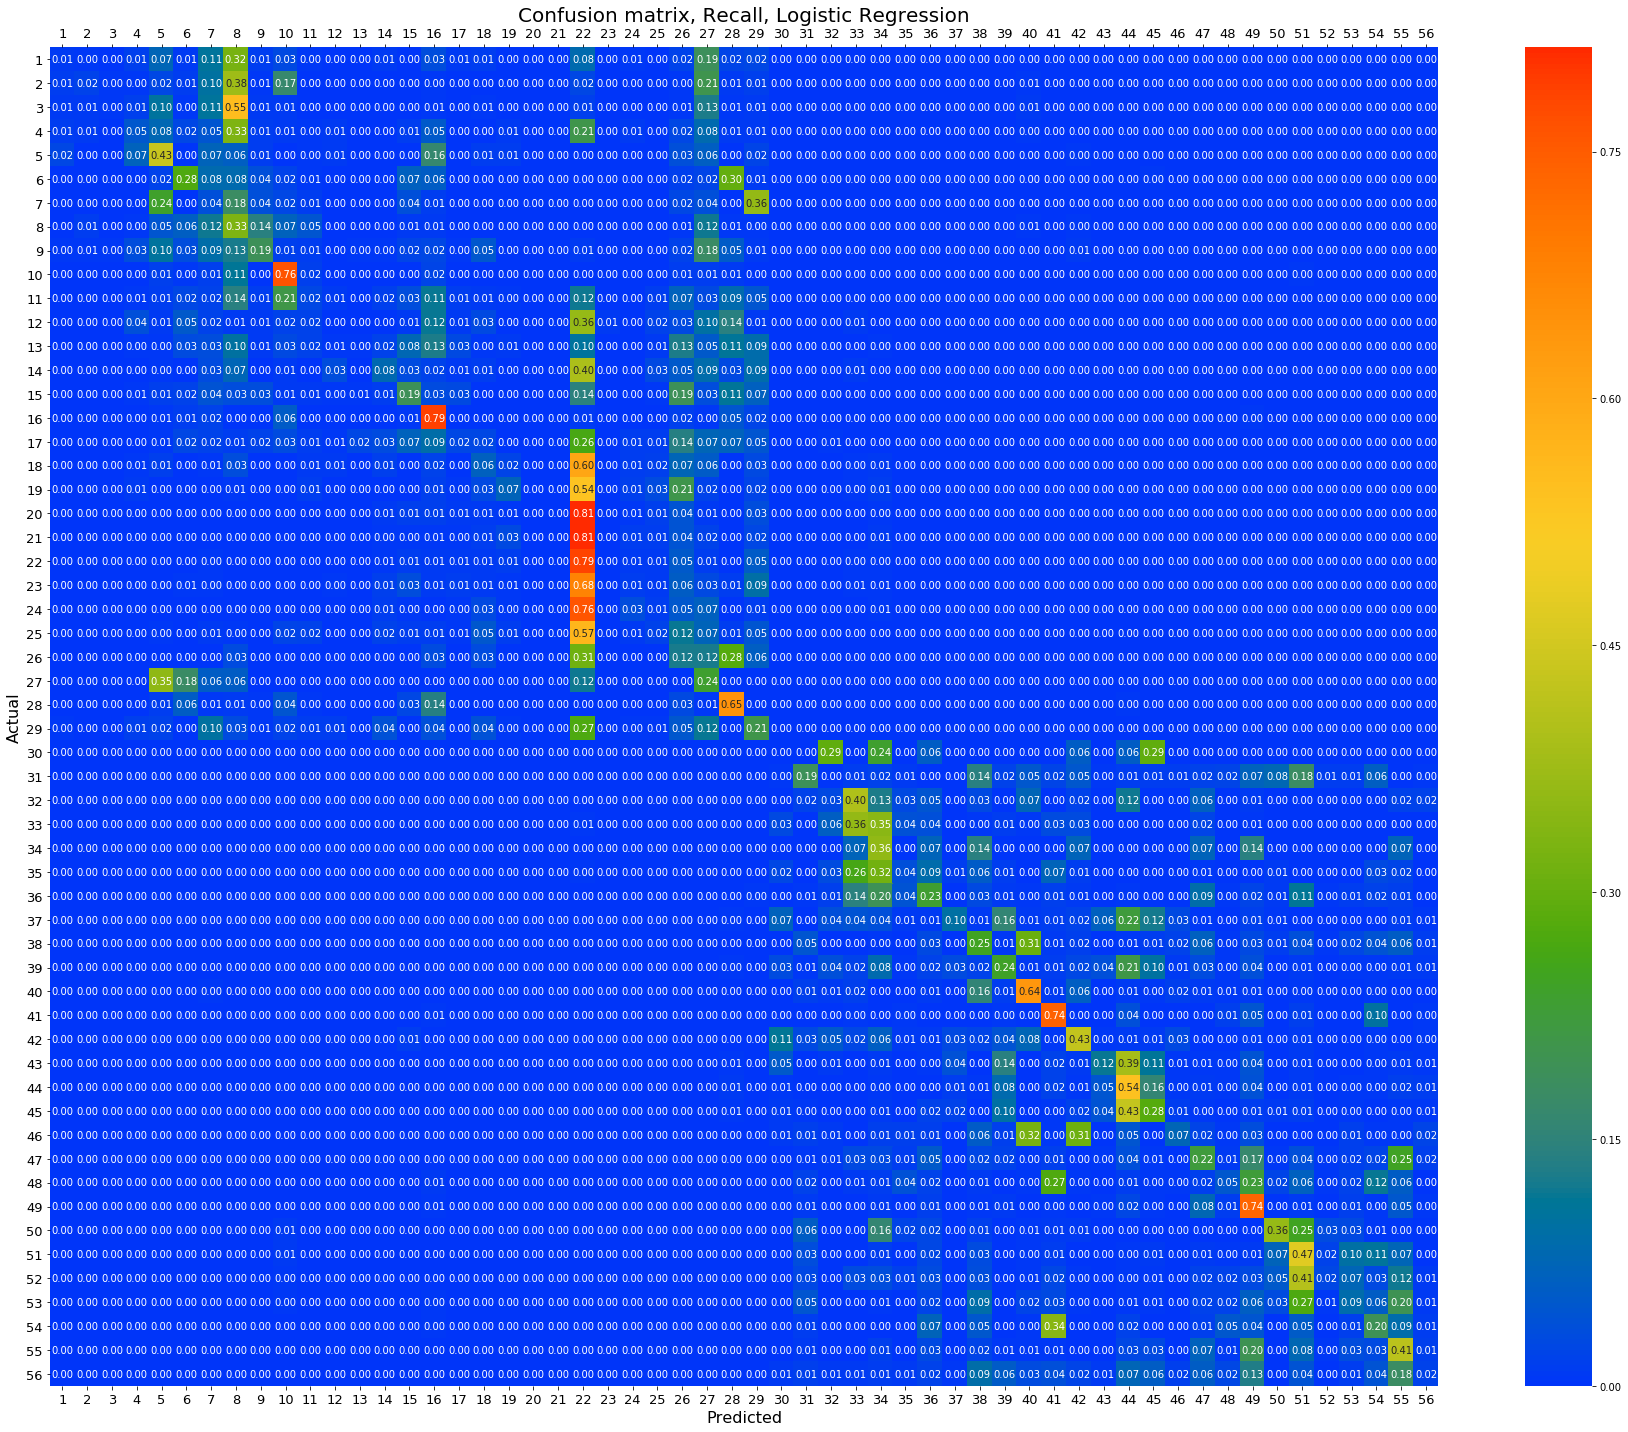

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='svg', xlabels=FDAcodes, type='recall',
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix (normalized by column)

* diagonal elements now represent the *precision* for each class

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='svg', xlabels=FDAcodes, type='precision',
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

In [ ]:
del LR

In [ ]:
for i in range(2):
    print('\nCollecting {} ...'.format(i))
    n = gc.collect()
    print('Unreachable objects:', n)
    print('Remaining Garbage:', end=' ')
    pprint.pprint(gc.garbage)